#Librerie

In [30]:
!pip install yfinance

In [31]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Input

In [32]:
# seleziona i tickers del tuo portafoglio
#tickers = ['GLD','VT','VTI','BND','QQQ','SPY']
tickers = ['SWDA.MI','EIMI.MI','SGLD.MI','BND']

# seleziona quanto andare indietro
anni = 10

# percentuali min/max in portafoglio
min = 0
max = 1

# seleziona risk free rate
risk_free_rate=0.025

# Elaborazione portafogli ottimali

In [33]:
def rendimento(percentuali, log_returns):
  return np.sum(log_returns.mean()*percentuali) * 252

In [34]:
def rendimento_negativo(percentuali, log_returns):
  return -rendimento(percentuali, log_returns)

In [35]:
def deviazione_standard(percentuali, matrice_cov):
  return np.sqrt(percentuali.T @ matrice_cov @ percentuali)

In [36]:
def sharpe(percentuali, log_returns, matrice_cov, risk_free_rate):
  return(rendimento(percentuali,log_returns)- risk_free_rate) / deviazione_standard (percentuali, matrice_cov)

In [37]:
def sharpe_ratio_negativo(percentuali, log_returns, matrice_cov, risk_free_rate):
  return -sharpe(percentuali, log_returns, matrice_cov, risk_free_rate)

In [38]:
# funzione di massimizzazione dell'indice di sharpe
def max_sharpe(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  constraints = {'type':'eq','fun':lambda percentuali:np.sum(percentuali) -1}
  bounds = [bound for _ in range(len(tickers))]

  # funzione di ottimizzazione
  ottimizzazione = minimize(sharpe_ratio_negativo, np.array([1/len(tickers)]*len(tickers)), args=(log_returns, matrice_cov, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

  #pesi ottimali
  pesi_ottimali = ottimizzazione.x

  return pesi_ottimali

In [39]:
# funzione di minimizzazione della volatilità
def min_volatilita(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  constraints = {'type':'eq','fun':lambda percentuali:np.sum(percentuali) -1}
  bounds = [bound for _ in range(len(tickers))]

  # funzione di ottimizzazione
  ottimizzazione = minimize(deviazione_standard, np.array([1/len(tickers)]*len(tickers)), args=(matrice_cov), method='SLSQP', constraints=constraints, bounds=bounds)

  #pesi ottimali
  pesi_ottimali = ottimizzazione.x

  return pesi_ottimali

In [40]:
# funzione di massimizzazione del rendimento
def max_rendimento(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  constraints = {'type':'eq','fun':lambda percentuali:np.sum(percentuali) -1}
  bounds = [bound for _ in range(len(tickers))]

  # funzione di ottimizzazione
  ottimizzazione = minimize(rendimento_negativo, np.array([1/len(tickers)]*len(tickers)), args=(log_returns), method='SLSQP', constraints=constraints, bounds=bounds)

  #pesi ottimali
  pesi_ottimali = ottimizzazione.x

  return pesi_ottimali

In [41]:
# recupera prezzi adjusted
data_fine = dt.datetime.now()
data_inizio = data_fine - dt.timedelta(days=365*anni)
adjclose = yf.download(tickers, start=data_inizio, end=data_fine)['Adj Close']

# rendimenti
log_returns=np.log(adjclose/adjclose.shift(1))
log_returns=log_returns.dropna()
log_returns=log_returns.reindex(tickers,axis=1)

# covarianza
matrice_cov = log_returns.cov() * 252

[*********************100%***********************]  4 of 4 completed


In [42]:
rendimento_portafoglio_ottimale = rendimento(max_sharpe(log_returns, matrice_cov, risk_free_rate), log_returns)
volatilita_portafoglio_ottimale = deviazione_standard(max_sharpe(log_returns, matrice_cov, risk_free_rate), matrice_cov)
sharpe_ratio_ottimale = sharpe(max_sharpe(log_returns, matrice_cov, risk_free_rate), log_returns, matrice_cov, risk_free_rate)
equity_line_portafoglio_ottimale = log_returns @ max_sharpe(log_returns, matrice_cov, risk_free_rate)

In [43]:
rendimento_portafoglio_minvol = rendimento(min_volatilita(log_returns, matrice_cov, risk_free_rate), log_returns)
volatilita_portafoglio_minvol = deviazione_standard(min_volatilita(log_returns, matrice_cov, risk_free_rate), matrice_cov)
sharpe_ratio_minvol = sharpe(min_volatilita(log_returns, matrice_cov, risk_free_rate), log_returns, matrice_cov, risk_free_rate)
equity_line_portafoglio_minval = log_returns @ min_volatilita(log_returns, matrice_cov, risk_free_rate)

In [44]:
rendimento_portafoglio_maxrend = rendimento(max_rendimento(log_returns, matrice_cov, risk_free_rate), log_returns)
volatilita_portafoglio_maxrend = deviazione_standard(max_rendimento(log_returns, matrice_cov, risk_free_rate), matrice_cov)
sharpe_ratio_maxrend = sharpe(max_rendimento(log_returns, matrice_cov, risk_free_rate), log_returns, matrice_cov, risk_free_rate)
equity_line_portafoglio_maxrend = log_returns @ max_rendimento(log_returns, matrice_cov, risk_free_rate)

# Portafogli ottimali

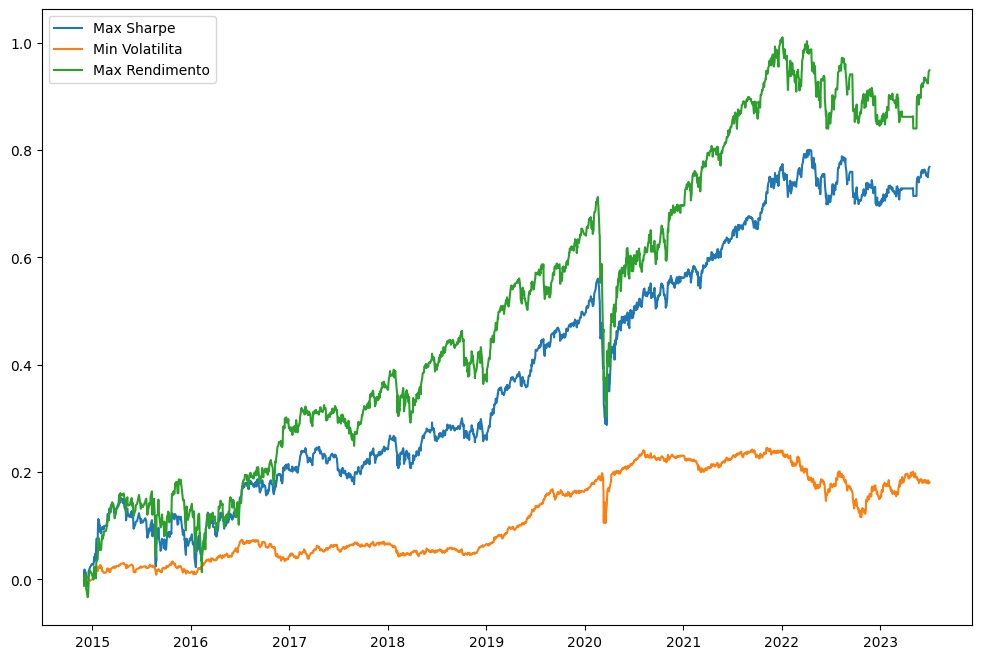

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(equity_line_portafoglio_ottimale.cumsum(), label='Max Sharpe')
plt.plot(equity_line_portafoglio_minval.cumsum(), label = 'Min Volatilita')
plt.plot(equity_line_portafoglio_maxrend.cumsum(), label= 'Max Rendimento')
plt.legend()
plt.show()

In [46]:
# portafoglio max sharpe
print("\nMetriche di portafoglio Max Sharpe")
print(f"Rendimento Annuale atteso: {rendimento_portafoglio_ottimale*100:.2f}%")
print(f"Volatilita attesa: {volatilita_portafoglio_ottimale*100:.2f}%")
print(f"Indice di Sharpe atteso: {sharpe_ratio_ottimale:.4f}")
print("Asset Allocation:")
for ticker, percentuale in zip(tickers,max_sharpe(log_returns, matrice_cov, risk_free_rate)):
  print(f"{ticker}: {percentuale*100:.1f}%")


Metriche di portafoglio Max Sharpe
Rendimento Annuale atteso: 9.89%
Volatilita attesa: 11.96%
Indice di Sharpe atteso: 0.6179
Asset Allocation:
SWDA.MI: 63.8%
EIMI.MI: 0.0%
SGLD.MI: 36.2%
BND: 0.0%


In [47]:
# portafoglio min volatilita
print("\nMetriche di portafoglio Min Volatilita")
print(f"Rendimento Annuale atteso: {rendimento_portafoglio_minvol*100:.2f}%")
print(f"Volatilita attesa: {volatilita_portafoglio_minvol*100:.2f}%")
print(f"Indice di Sharpe atteso: {sharpe_ratio_minvol:.4f}")
print("Asset Allocation:")
for ticker, percentuale in zip(tickers,min_volatilita(log_returns, matrice_cov, risk_free_rate)):
  print(f"{ticker}: {percentuale*100:.1f}%")


Metriche di portafoglio Min Volatilita
Rendimento Annuale atteso: 2.33%
Volatilita attesa: 5.06%
Indice di Sharpe atteso: -0.0343
Asset Allocation:
SWDA.MI: 8.3%
EIMI.MI: 0.0%
SGLD.MI: 8.4%
BND: 83.3%


In [48]:
# portafoglio max rendimento
print("\nMetriche di portafoglio Max Rendimento")
print(f"Rendimento Annuale atteso: {rendimento_portafoglio_maxrend*100:.2f}%")
print(f"Volatilita attesa: {volatilita_portafoglio_maxrend*100:.2f}%")
print(f"Indice di Sharpe atteso: {sharpe_ratio_maxrend:.4f}")
print("Asset Allocation:")
for ticker, percentuale in zip(tickers,max_rendimento(log_returns, matrice_cov, risk_free_rate)):
  print(f"{ticker}: {percentuale*100:.1f}%")


Metriche di portafoglio Max Rendimento
Rendimento Annuale atteso: 12.20%
Volatilita attesa: 17.08%
Indice di Sharpe atteso: 0.5679
Asset Allocation:
SWDA.MI: 100.0%
EIMI.MI: 0.0%
SGLD.MI: 0.0%
BND: 0.0%


 # Portafoglio ottimale (old)

Metriche di portafoglio
Rendimento Annuale atteso: 9.89%
Volatilita attesa: 11.96%
Indice di Sharpe atteso: 0.6179



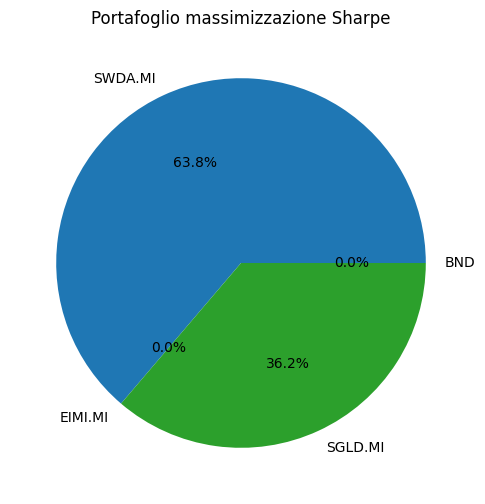

In [49]:
# portafoglio massimizzazione sharpe
plt.figure(figsize=(10,6))

plt.pie(max_sharpe(log_returns, matrice_cov, risk_free_rate), labels=tickers, autopct='%1.1f%%')
#plt.bar(tickers, max_sharpe(log_returns, matrice_cov, risk_free_rate))
plt.title("Portafoglio massimizzazione Sharpe")
print("Metriche di portafoglio")
print(f"Rendimento Annuale atteso: {rendimento_portafoglio_ottimale*100:.2f}%")
print(f"Volatilita attesa: {volatilita_portafoglio_ottimale*100:.2f}%")
print(f"Indice di Sharpe atteso: {sharpe_ratio_ottimale:.4f}\n")

plt.show()

Metriche di portafoglio
Rendimento Annuale atteso: 2.33%
Volatilita attesa: 5.06%
Indice di Sharpe atteso: -0.0343



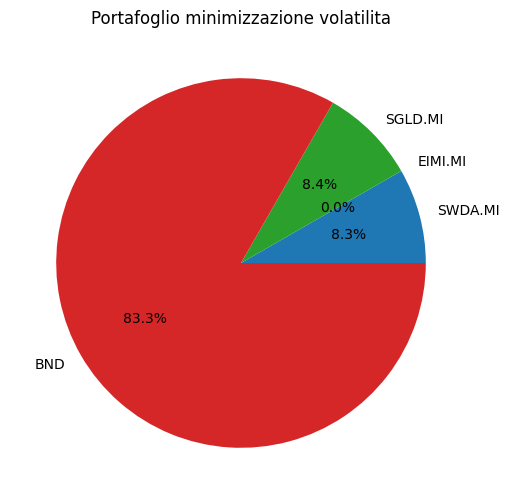

In [50]:
# portafoglio minimizzazione volatilità
plt.figure(figsize=(10,6))

plt.pie(min_volatilita(log_returns, matrice_cov, risk_free_rate), labels=tickers, autopct='%1.1f%%')
#plt.bar(tickers, min_volatilita(log_returns, matrice_cov, risk_free_rate))
plt.title("Portafoglio minimizzazione volatilita")
print("Metriche di portafoglio")
print(f"Rendimento Annuale atteso: {rendimento_portafoglio_minvol*100:.2f}%")
print(f"Volatilita attesa: {volatilita_portafoglio_minvol*100:.2f}%")
print(f"Indice di Sharpe atteso: {sharpe_ratio_minvol:.4f}\n")

plt.show()

Metriche di portafoglio
Rendimento Annuale atteso: 12.20%
Volatilita attesa: 17.08%
Indice di Sharpe atteso: 0.5679



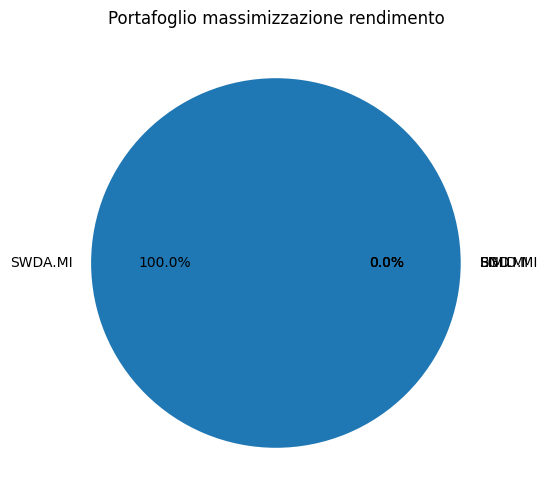

In [51]:
# portafoglio massimizzazione rendimento
plt.figure(figsize=(10,6))

plt.pie(max_rendimento(log_returns, matrice_cov, risk_free_rate), labels=tickers, autopct='%1.1f%%')
#plt.bar(tickers, max_rendimento(log_returns, matrice_cov, risk_free_rate))
plt.title("Portafoglio massimizzazione rendimento")
print("Metriche di portafoglio")
print(f"Rendimento Annuale atteso: {rendimento_portafoglio_maxrend*100:.2f}%")
print(f"Volatilita attesa: {volatilita_portafoglio_maxrend*100:.2f}%")
print(f"Indice di Sharpe atteso: {sharpe_ratio_maxrend:.4f}\n")

plt.show()

# Elaborazione frontiera efficiente

In [52]:
def portfolio_performance(percentuali, log_returns, matrice_cov):
  rend = rendimento(percentuali, log_returns)
  stdev = deviazione_standard(percentuali, matrice_cov)
  return rend, stdev

In [53]:
def rend_portafoglio(percentuali, log_returns, matrice_cov):
  return portfolio_performance(percentuali, log_returns, matrice_cov)[0]

In [54]:
def frontiera_efficiente(log_returns, matrice_cov, target, bound=(min,max)):
  constraints = ({'type':'eq','fun':lambda percentuali:rend_portafoglio(percentuali, log_returns, matrice_cov)-target},
                {'type':'eq','fun':lambda percentuali:np.sum(percentuali)-1})
  bounds = [bound for _ in range(len(tickers))]
  frontiera = minimize(deviazione_standard, np.array([1/len(tickers)]*len(tickers)), args=(matrice_cov), method='SLSQP', constraints=constraints, bounds=bounds)
  return frontiera

In [55]:
def FrontieraEff(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  # portafoglio max sharpe
  maxSR_portfolio = max_sharpe(log_returns, matrice_cov, risk_free_rate)
  maxSR_rendimento = rendimento(maxSR_portfolio, log_returns)
  maxSR_deviazione_std = deviazione_standard(maxSR_portfolio, matrice_cov)
  maxSR_allocazione = pd.DataFrame(maxSR_portfolio, index=log_returns.mean().index, columns=['allocazione'])
  maxSR_allocazione.allocazione = [round(i*100,0) for i in maxSR_allocazione.allocazione]

  # portafoglio min stdev
  minvol_portfolio = min_volatilita(log_returns, matrice_cov, risk_free_rate)
  minvol_rendimento = rendimento(minvol_portfolio, log_returns)
  minvol_deviazione_std = deviazione_standard(minvol_portfolio, matrice_cov)
  minvol_allocazione = pd.DataFrame(minvol_portfolio, index=log_returns.mean().index, columns=['allocazione'])
  minvol_allocazione.allocazione = [round(i*100,0) for i in minvol_allocazione.allocazione]

  # portafoglio max rendimento
  maxrend_portfolio = max_rendimento(log_returns, matrice_cov, risk_free_rate)
  maxrend_rendimento = rendimento(maxrend_portfolio, log_returns)
  maxrend_deviazione_std = deviazione_standard(maxrend_portfolio, matrice_cov)
  maxrend_allocazione = pd.DataFrame(maxrend_portfolio, index=log_returns.mean().index, columns=['allocazione'])
  maxrend_allocazione.allocazione = [round(i*100,0) for i in maxrend_allocazione.allocazione]

  # frontiera
  lista_efficienza = []
  target = np.linspace(minvol_rendimento, maxrend_rendimento, 1000)
  for tgt in target:
    lista_efficienza.append(frontiera_efficiente(log_returns, matrice_cov, tgt)['fun'])

  return maxSR_rendimento, maxSR_deviazione_std, maxSR_allocazione, minvol_rendimento, minvol_deviazione_std, minvol_allocazione, maxrend_rendimento, maxrend_deviazione_std, maxrend_allocazione, np.array(lista_efficienza), target

In [56]:
def grafico_EF(log_returns, matrice_cov, risk_free_rate, bound=(min,max)):
  maxSR_rendimento, maxSR_deviazione_std, maxSR_allocazione, minvol_rendimento, minvol_deviazione_std, minvol_allocazione, maxrend_rendimento, maxrend_deviazione_std, maxrend_allocazione, lista_efficienza, target = FrontieraEff(log_returns, matrice_cov, risk_free_rate)

  maxSR_rendimento = round(maxSR_rendimento*100,2)
  maxSR_deviazione_std = round(maxSR_deviazione_std*100,2)
  minvol_rendimento = round(minvol_rendimento*100,2)
  minvol_deviazione_std = round(minvol_deviazione_std*100,2)
  maxrend_rendimento = round(maxrend_rendimento*100,2)
  maxrend_deviazione_std = round(maxrend_deviazione_std*100,2)
  lista_efficienza = [round(le*100,2) for le in lista_efficienza]
  target = [round(tg*100,2) for tg in target]

  # Max Sharpe Ratio
  MaxSharpe = go.Scatter(
      name='Max Sharpe Ratio',
      mode='markers',
      x=[maxSR_deviazione_std],
      y=[maxSR_rendimento],
      hoverinfo=None,
      marker=dict(color='red',size=12,line=dict(width=1,color='black'))
  )

  # Min Volatility
  MinVol = go.Scatter(
      name='Min Volatilita',
      mode='markers',
      x=[minvol_deviazione_std],
      y=[minvol_rendimento],
      marker=dict(color='blue',size=8,line=dict(width=1,color='black'))
  )

  # Max Rendimento
  MaxRend = go.Scatter(
      name='Max Rendimento',
      mode='markers',
      x=[maxrend_deviazione_std],
      y=[maxrend_rendimento],
      marker=dict(color='black',size=8,line=dict(width=1,color='black'))
  )

  # Frontiera Efficiente
  curvaEF = go.Scatter(
      name='Curva di Frontiera',
      mode='lines',
      x=lista_efficienza,
      y=target,
      line=dict(color='black', width=2)
  )

  data = [curvaEF,MaxSharpe,MinVol,MaxRend]

  layout = go.Layout(
      title='Frontiera Efficiente',
      yaxis=dict(title='Rendimento annuale (%)'),
      xaxis=dict(title='Volatilita annuale (%)'),
      showlegend=False,
      #legend=dict(x=0.85,y=0,traceorder='normal',bgcolor='#E2E2E2',bordercolor='black',borderwidth=1),
      width=1200,
      height=800
  )

  fig=go.Figure(data=data, layout=layout)
  return fig.show()

# Frontiera Efficiente

In [57]:
grafico_EF(log_returns, matrice_cov, risk_free_rate)